# Prelude

In [ ]:
from pyiron_atomistics import Project

In [ ]:
import pyiron_potentialfit.assyst.calculations as pcalc

In [4]:
pr = Project('W').create_group('training')

# CLI

The command line below is largely equivalent to this notebook.

`python -m pyiron_potentialfit.spgfit.calculations --kspacing 0.25 --encut 300 --containers W4 W4VolMin W4VolMinAllMin --final W4Only --cores 10 --runtime 600 --fast-forward 360`

# Python

## Run DFT

Configuration options for running the DFT calculations.

In [5]:
conf = pcalc.CalculationConfig(
    # (optionally) pre-filter structures by minimum distance, if not given use RCORE from VASP default PAW
    min_dist = 2,
    vasp=pcalc.VaspConfig(
        encut=550, kmesh=0.1, 
        version='6.4.0_mpi',
        incar={
            'LCHARG': '.FALSE.',
            'ISMEAR': 0,         # gauss smearing
            'SIGMA': 0.05,
            'ALGO': 'Fast',
            'EDIFF': 1e-8,
            'NCORE': 5,
        }
    ),
    server=pcalc.ServerConfig(
        cores=40, 
        # queuing run time limit in seconds
        run_time=5*60*60, 
        # pyiron queue names
        queue='cmti',
    ),
    workflow=pcalc.WorkflowProjectConfig(
        # re-run DFT jobs
        delete_existing_job=False,
        # accept less than this aborted and unfixable jobs
        broken_threshold=0.05, 
        # once more than this amount of jobs are finished, collect the training containers and bail on the rest
        finished_threshold=0.9
    )
)

Here we need to pick which StructureContainers we want to run for our training set.

In [ ]:
containers = [
        pr['../structures/containers/W4'], 
        pr['../structures/containers/W4VolMin'],
        pr['../structures/containers/W4VolMinAllMin'],
        pr['../structures/containers/W4VolMinAllMinRandom'],
]

In [ ]:
pcalc.run(pr, conf, *containers, tries=5)

After each call to `run_container` has finished corresponding `TrainingContainer` will be places in `pr['containers']`.

In [39]:
pr['containers']

{'groups': [], 'nodes': ['W4', 'W4VolMinAllMin']}

## Inspect Data

Similarly to the `StructureContainer`s from the first notebook the `TrainingContainers` allow to plot some data about their contained structures.  Their plotting methods supports the same ones as the `StructureContainer` plus some that visualize energies and forces.

In [47]:
allmin = pr['containers'].load('W4VolMinAllMin')

,V,E
0,18.385827,-11.484599
1,17.503111,-11.788538
2,15.993010,-12.949594
3,15.662797,-12.897673
4,15.839552,-12.910944
...,...,...
234,16.445127,-12.471459
235,17.529110,-11.811027
236,16.044270,-12.950071
237,18.119871,-11.483745


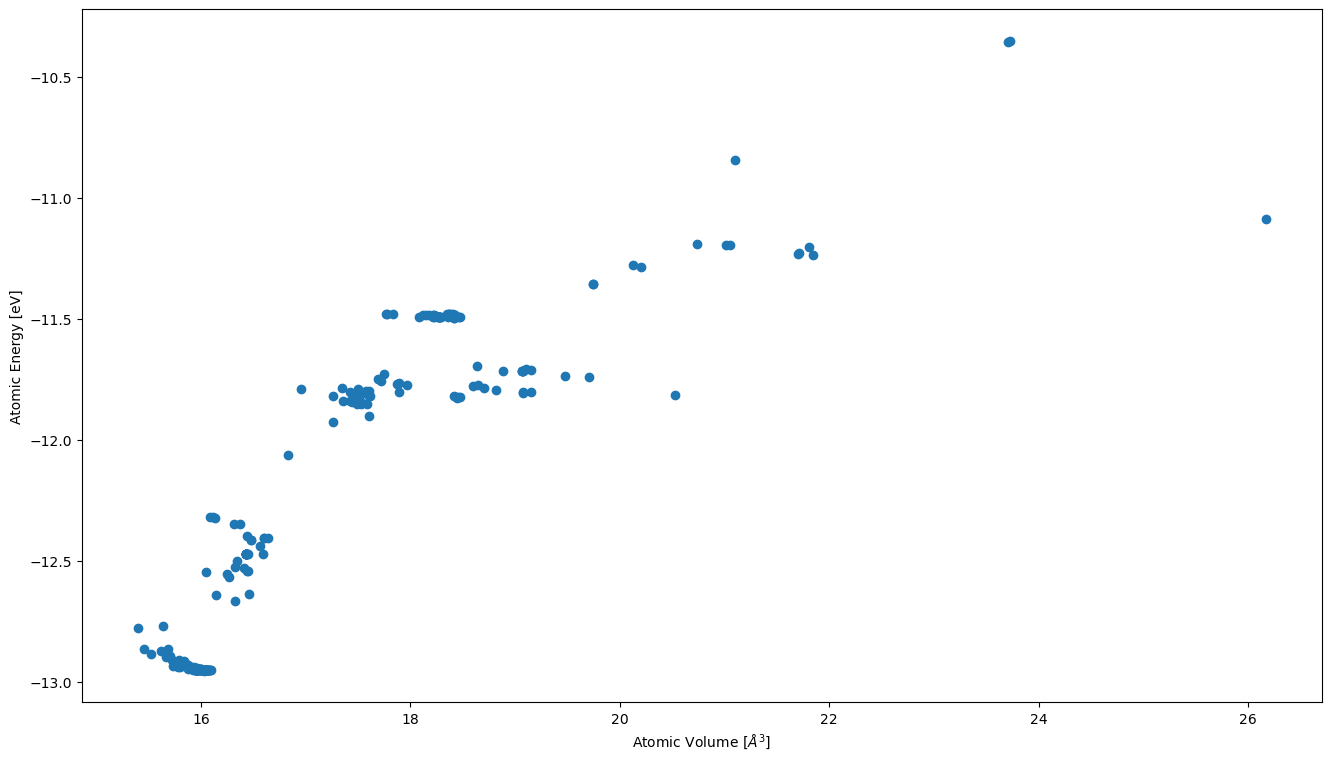

In [48]:
allmin.plot.energy_volume()

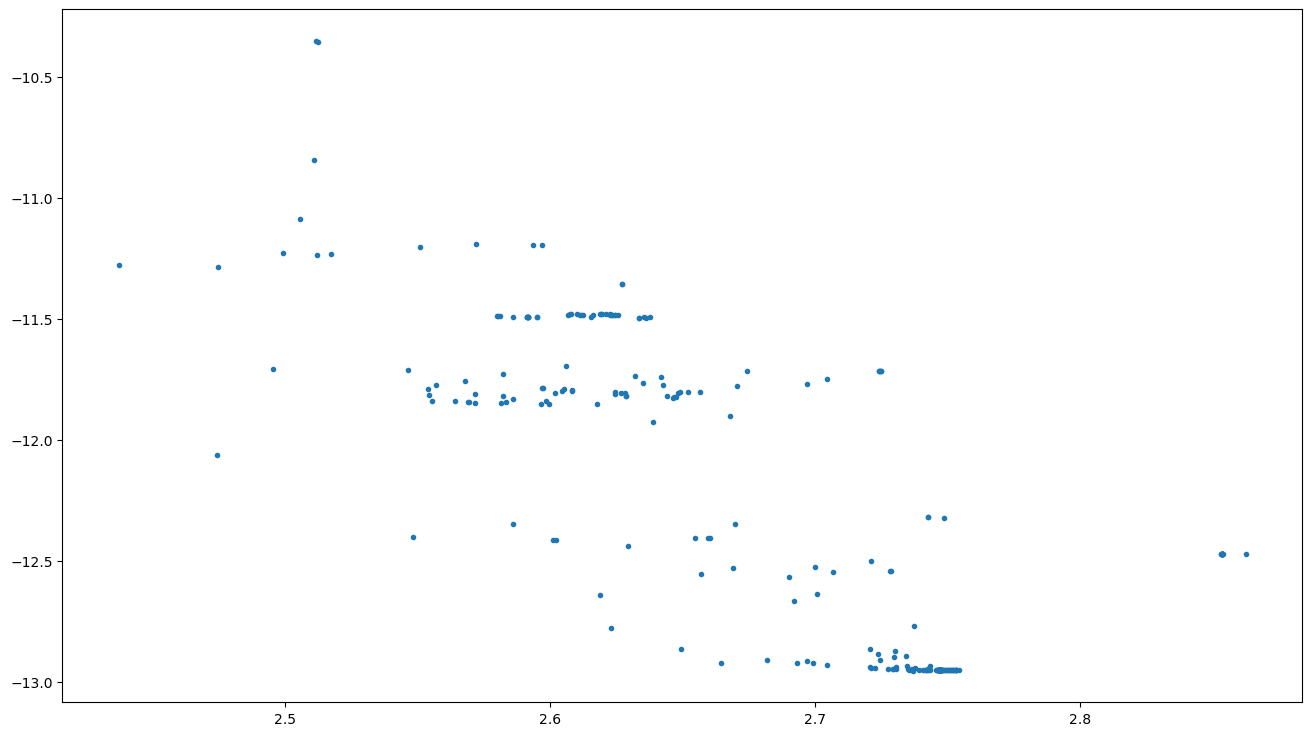

In [49]:
allmin.plot.energy_distance()

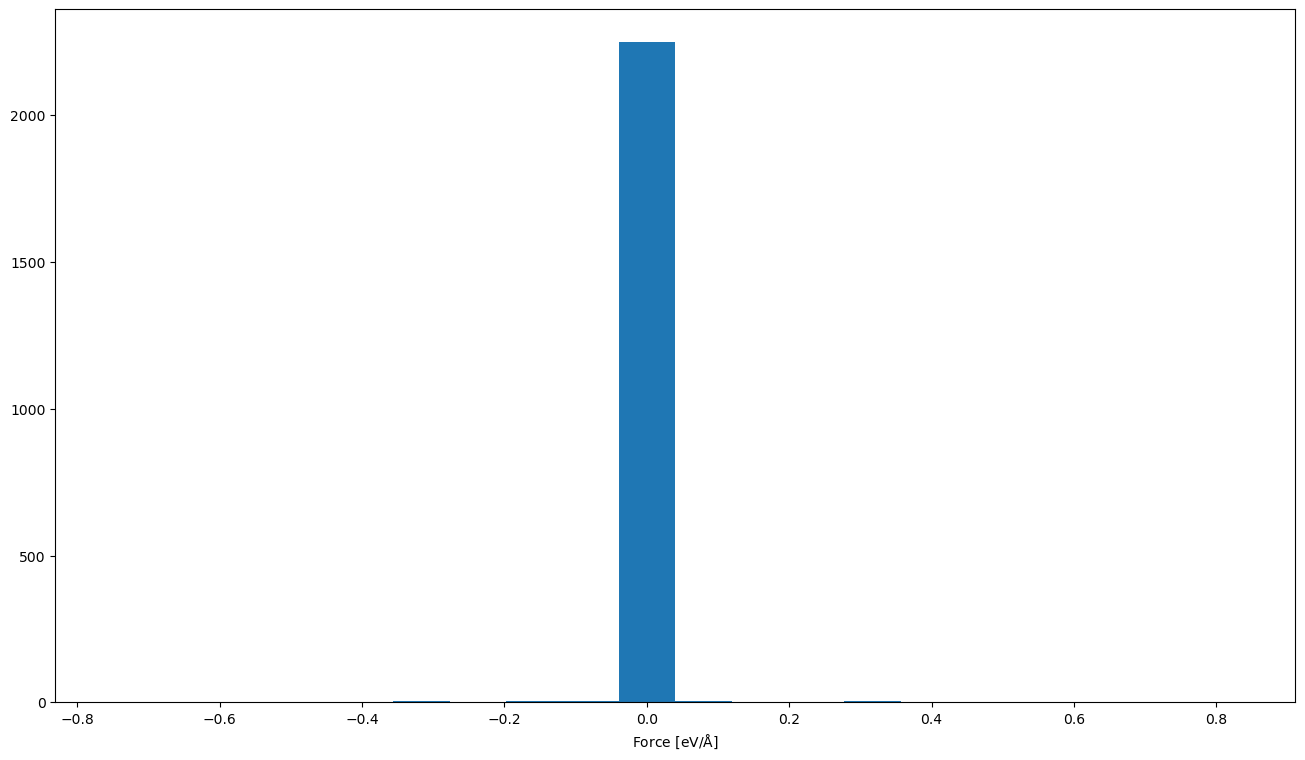

In [50]:
allmin.plot.forces()

## Collecting

Once all containers are done, use the `combine` function to create a combined training set and apply some filters.

In [41]:
pcalc.combine?

Signature:
pcalc.combine(
    pr: pyiron_base.project.generic.Project,
    containers: Iterable[pyiron_potentialfit.atomistics.job.trainingcontainer.TrainingContainer],
    name='Everything',
    min_dist=None,
    force_cap=None,
    check_duplicates=True,
    delete_existing_job=False,
) -> pyiron_potentialfit.atomistics.job.trainingcontainer.TrainingContainer
Docstring:
Combine a list of training containers into a new container.

Args:
    pr (Project): where to put the new container
    containers (iterable of TrainingContainer): containers to combine
    min_dist (float or dict of str to float, optional): if given, filter structures that are have atoms than this;
            if a dict it specifies the minimal allowed radii of each element
    force_cap (float): filter structures that have atomic forces larger than this value
    check_duplicates (bool): discard duplicated structures; some care has been taken to optimize this, but it can be
            costly for large datasets
   

In [56]:
every = pcalc.combine(
    pr['containers'],
    name='W4_Everything',
    containers=[
        pr['containers/W4'], 
        pr['containers/W4VolMinAllMin'],
        # add here more containers if you ran more
    ],
    # it's advisable to filter by minimum distances or large forces to avoid a lot of samples in the strongly repulsive limit;
    # those can negatively affect the fitting results for MTPs.  I tend to run dimer calculations in VASP to get a feeling as 
    # to at what distances the energies and forces because unreasonable.
    min_dist = None,
    force_cap = 7.5, # eV/A
)

The job W4_Everything was saved and received the ID: 21896541


  0%|          | 0/589 [00:00<?, ?it/s]

The job W4_Everything was saved and received the ID: 21896542
Queue system id:  7161336


,V,E
0,37.986321,-7.737205
1,47.343678,-6.355042
2,33.391257,-8.619449
3,43.335947,-7.055567
4,39.204455,-7.646501
...,...,...
582,16.445127,-12.471459
583,17.529110,-11.811027
584,16.044270,-12.950071
585,18.119871,-11.483745


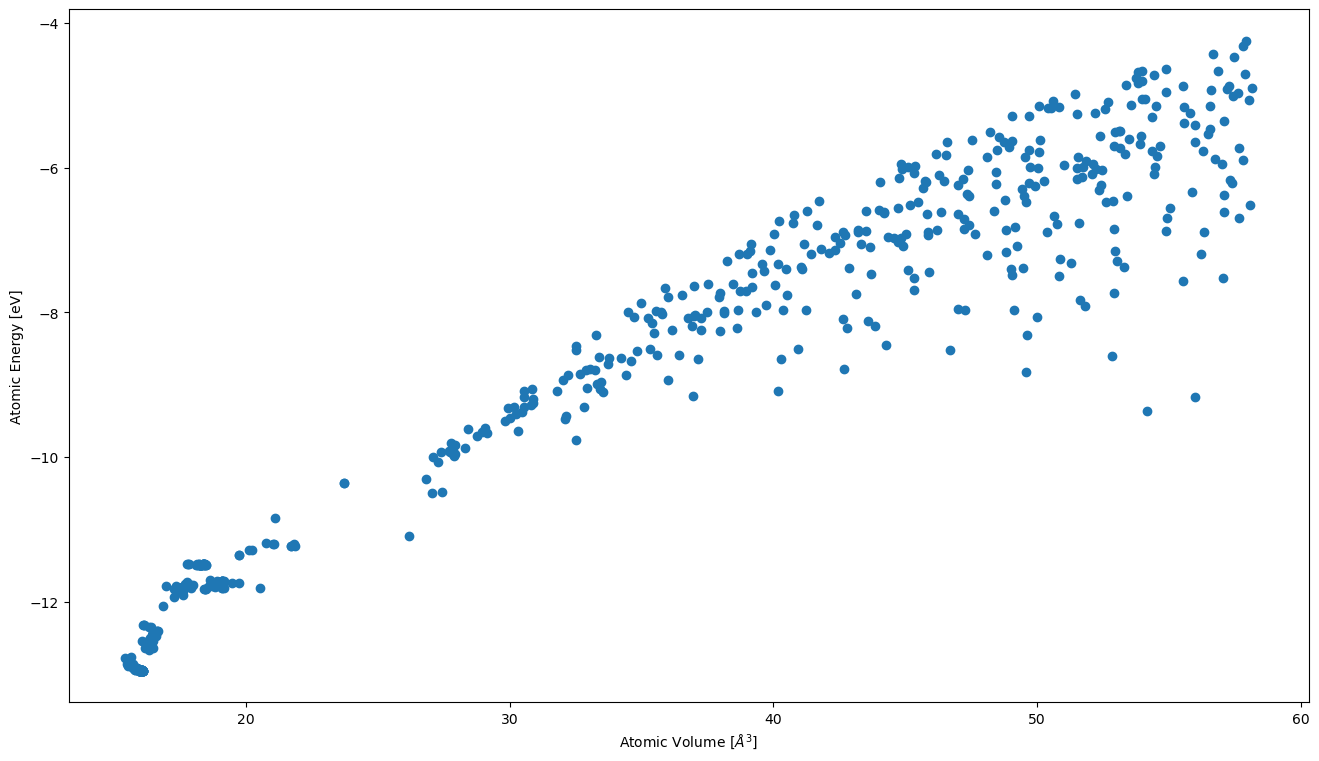

In [57]:
every.plot.energy_volume()

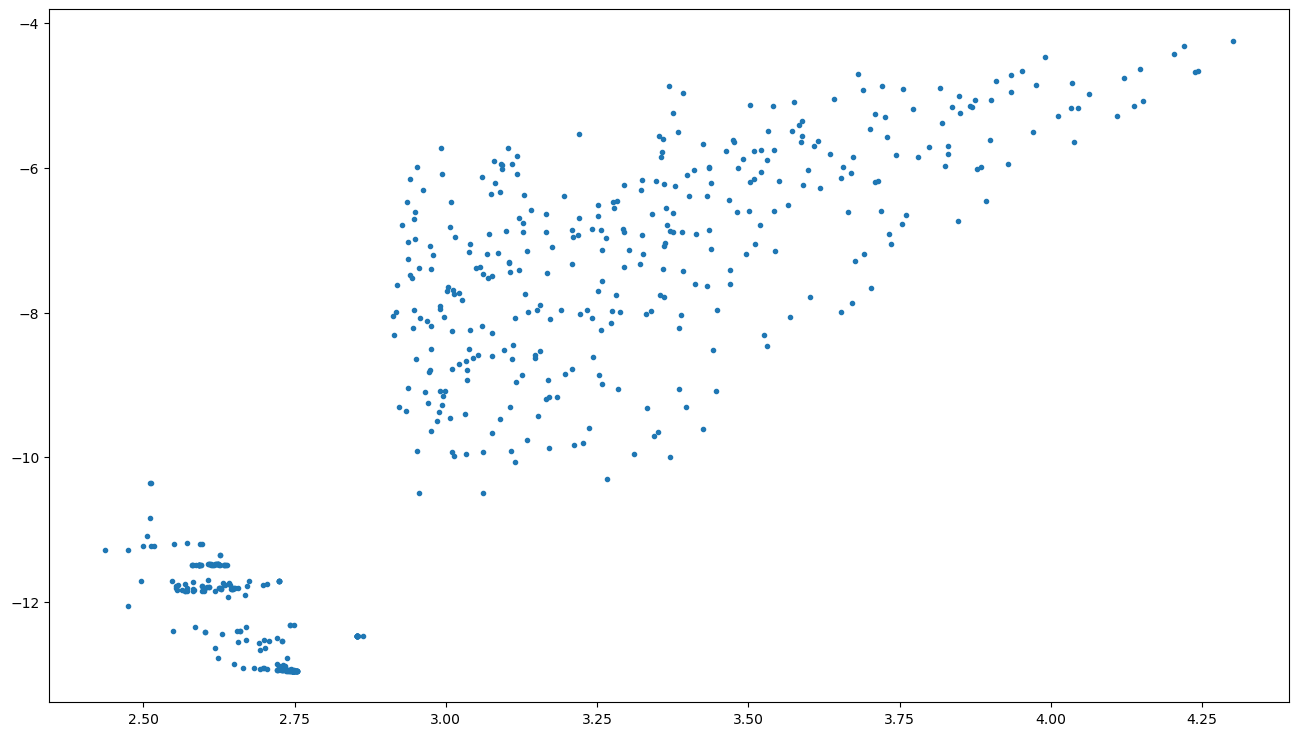

In [58]:
every.plot.energy_distance()